# Evaluation, Prediction & Visualization for the Best Model

In [1]:
import sys
import os
from os import pardir, getcwd
from os.path import join, abspath
PARENT_DIRECTORY = abspath(join(getcwd(), pardir))
sys.path.insert(0, PARENT_DIRECTORY)

import warnings
import sklearn.exceptions
import numpy as np
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from definitions import TALOS_DIR
from app.preprocessing import (load_dataset,
                               load_embeddings,
                               preprocess_data,
                               save_embeddings_matrix)
from app.models import (load_bi_gru_model, 
                        load_bi_lstm_model, 
                        find_best_model_over_scan_logs)

from app.visualization import (plot_prediction_metrics,
                               create_clf_report,
                               plot_confusion_matrix)

#Comment out In case of Testing use only a set of the tags as dataset
# tags_categories = ['c', 'python', 'java']
# RUN_STATE = 'testing'

#Comment out In case of Production use all the tags of the dataset
tags_categories = "__all__"
RUN_STATE = 'production'


Using TensorFlow backend.


In [2]:
data = load_dataset(tags_categories=tags_categories, load_from_pickle=True)
classes_counts =data['tags'].value_counts().where(lambda cls: cls > 0).dropna() 
Classes = list(classes_counts.index)
Nclasses = len(Classes)
print(classes_counts, Classes, Nclasses)

python    2000.0
c         2000.0
java      2000.0
Name: tags, dtype: float64 ['python', 'c', 'java'] 3


 ### Hyper parameter tuning for the  model

In [3]:
# 80% Train & 20% Test
# 70% Train-Dev % 30* Train-Dev 
embeddings_voc, embeddings_vec = load_embeddings(load_from_pickle=True)
model_data = preprocess_data(data,
                             'tags',
                             'post',
                             cv_split_full=0.2,
                             cv_split_dev=0.125)

### Find the Best Model Against the Talos Scans

In [12]:

# RNN BiGRU Talos configuration filepath 
TALOS_BiGRU_DEEP_LOG_FILENAME = 'talos_bigru_deep_log_.csv'
talos_bigru_deep_log_pathname = os.path.join(TALOS_DIR, TALOS_BiGRU_DEEP_LOG_FILENAME)

TALOS_BiGRU_DEEP_MUTLI_LOG_FILENAME = 'talos_bigru_deep_multi_log_.csv'
talos_bigru_deep_multi_log_pathname = os.path.join(TALOS_DIR, TALOS_BiGRU_DEEP_MUTLI_LOG_FILENAME)

# RNN BiLSTM Talos configuration filepath
TALOS_LSTM_DEEP_LOG_FILENAME = 'talos_lstm_deep_log_.csv'
talos_lstm_deep_log_pathname = os.path.join(TALOS_DIR, TALOS_LSTM_DEEP_LOG_FILENAME)

TALOS_LSTM_DEEP_MULTI_LOG_FILENAME = 'talos_lstm_deep_multi_log_.csv'
talos_lstm_deep_multi_log_pathname = os.path.join(TALOS_DIR, TALOS_LSTM_DEEP_MULTI_LOG_FILENAME)

best_model_params = find_best_model_over_scan_logs('val_f1', *[talos_bigru_deep_log_pathname,
                                                               talos_bigru_deep_multi_log_pathname,
                                                               talos_lstm_deep_log_pathname,
                                                               talos_lstm_deep_multi_log_pathname])


    Check the model type and load the relevant processed data

In [13]:
best_model_params

{'accuracy': 0.960453516123246,
 'batch_size': 64,
 'categorical_accuracy': 0.939591836734694,
 'dense': 300,
 'early_stopping': True,
 'early_stopping_config__min_delta': 0,
 'early_stopping_config__mode': 'max',
 'early_stopping_config__monitor': 'val_f1',
 'early_stopping_config__patience': 5,
 'embedding_dim': 300,
 'embeddings_dropout': 0.2,
 'embeddings_matrix_path': 'embeddings-matrix-pickle',
 'epochs': 3,
 'f1': 0.9399723597935268,
 'gru_size': nan,
 'loss': 0.17908514921002242,
 'lstm_size': 200,
 'mlp_activation': 'softmax',
 'mlp_dropout': 0.2,
 'model_type': 'keras_deep_LSTM_model',
 'multistack_run': False,
 'optimizer': 'Adam',
 'precision': 0.9499369137303358,
 'recall': 0.9303401360544218,
 'rnn_activation': 'tanh',
 'round_epochs': 3,
 'val_accuracy': 0.973968251546224,
 'val_categorical_accuracy': 0.96,
 'val_f1': 0.9605989728655134,
 'val_loss': 0.14250475163970674,
 'val_precision': 0.9670416695731028,
 'val_recall': 0.9542857142857144,
 'var_dropout': 0.6,
 'visua

In [14]:

if best_model_params['model_type'] in ["keras_deep_BiGRU_model",
                                       "keras_deep_BiGRU_multi_model"]:
    talos_model_method = load_bi_gru_model

elif best_model_params['model_type'] in ["keras_deep_LSTM_model", 
                                         "keras_deep_LSTM_multi_model"]:
    talos_model_method = load_bi_lstm_model

    Train the model with the best params

In [15]:
# Add logging of each epoch run for the generation process of the best MLP Model
best_model_params['visualize_process'] = True
model_history, model = talos_model_method(model_data['x_train'],
                                          model_data['y_train'],
                                          model_data['x_train_dev'],
                                          model_data['y_train_dev'],
                                          best_model_params)

W0714 22:21:34.632545 140607084488512 deprecation_wrapper.py:119] From /home/giannhs/miniconda3/envs/text_analytics/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0714 22:21:34.645857 140607084488512 deprecation_wrapper.py:119] From /home/giannhs/miniconda3/envs/text_analytics/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0714 22:21:34.646572 140607084488512 deprecation_wrapper.py:119] From /home/giannhs/miniconda3/envs/text_analytics/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0714 22:21:34.924051 140607084488512 deprecation.py:506] From /home/giannhs/miniconda3/envs/text_analytics/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 600, 300)          6000600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 600, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 600, 400)          801600    
_________________________________________________________________
deep_attention_1 (DeepAttent [(None, 400), (None, 600) 160801    
_________________________________________________________________
dense_1 (Dense)              (None, 300)               120300    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 903       
Total para


Epoch 00001: val_accuracy improved from -inf to 0.92389, saving model to keras_deep_LSTM_model

Epoch 00001: val_f1 improved from -inf to 0.87845, saving model to keras_deep_LSTM_model



Epoch 00002: val_accuracy improved from 0.92389 to 0.94167, saving model to keras_deep_LSTM_model

Epoch 00002: val_f1 improved from 0.87845 to 0.90974, saving model to keras_deep_LSTM_model



Epoch 00003: val_accuracy improved from 0.94167 to 0.94722, saving model to keras_deep_LSTM_model

Epoch 00003: val_f1 improved from 0.90974 to 0.91896, saving model to keras_deep_LSTM_model



 ### Visualize Model History Scores

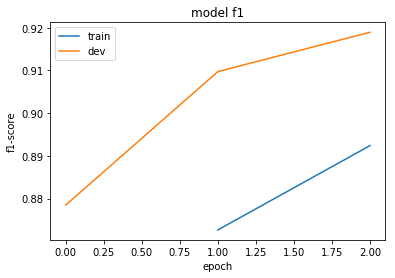

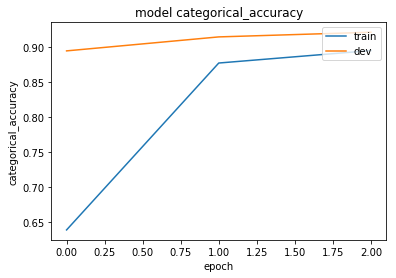

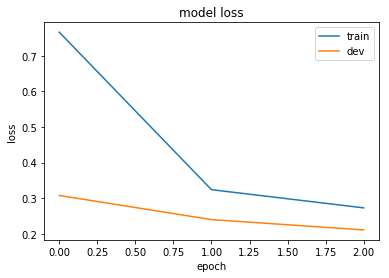

In [16]:
from app.visualization import plot_history_metrics
%matplotlib inline
plot_history_metrics(model_history)

### Evaluate performance model

Evaluates the performance of the best trained model in the **test** dataset. 

In [17]:
score = model.evaluate(model_data['x_test'],
                       model_data['y_test'],
                       batch_size=best_model_params['batch_size'],
                       verbose=1)

print('\nTest f1: %.4f' % (score[1]))
print('\nTest categorical accuracy: %.4f'% (score[2]))

1200/1200 [==============================] - 28s 23ms/step

Test f1: 0.9485

Test categorical accuracy: 0.9008


### Visualize Prediction Perfomance of centroids RNN model

--------------------------------------------------------------------------------
Accuracy Score: 92.42%
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

           0      0.955     0.902     0.928       400
           1      0.972     0.880     0.924       400
           2      0.920     0.920     0.920       400

   micro avg      0.948     0.901     0.924      1200
   macro avg      0.949     0.901     0.924      1200
weighted avg      0.949     0.901     0.924      1200
 samples avg      0.901     0.901     0.901      1200



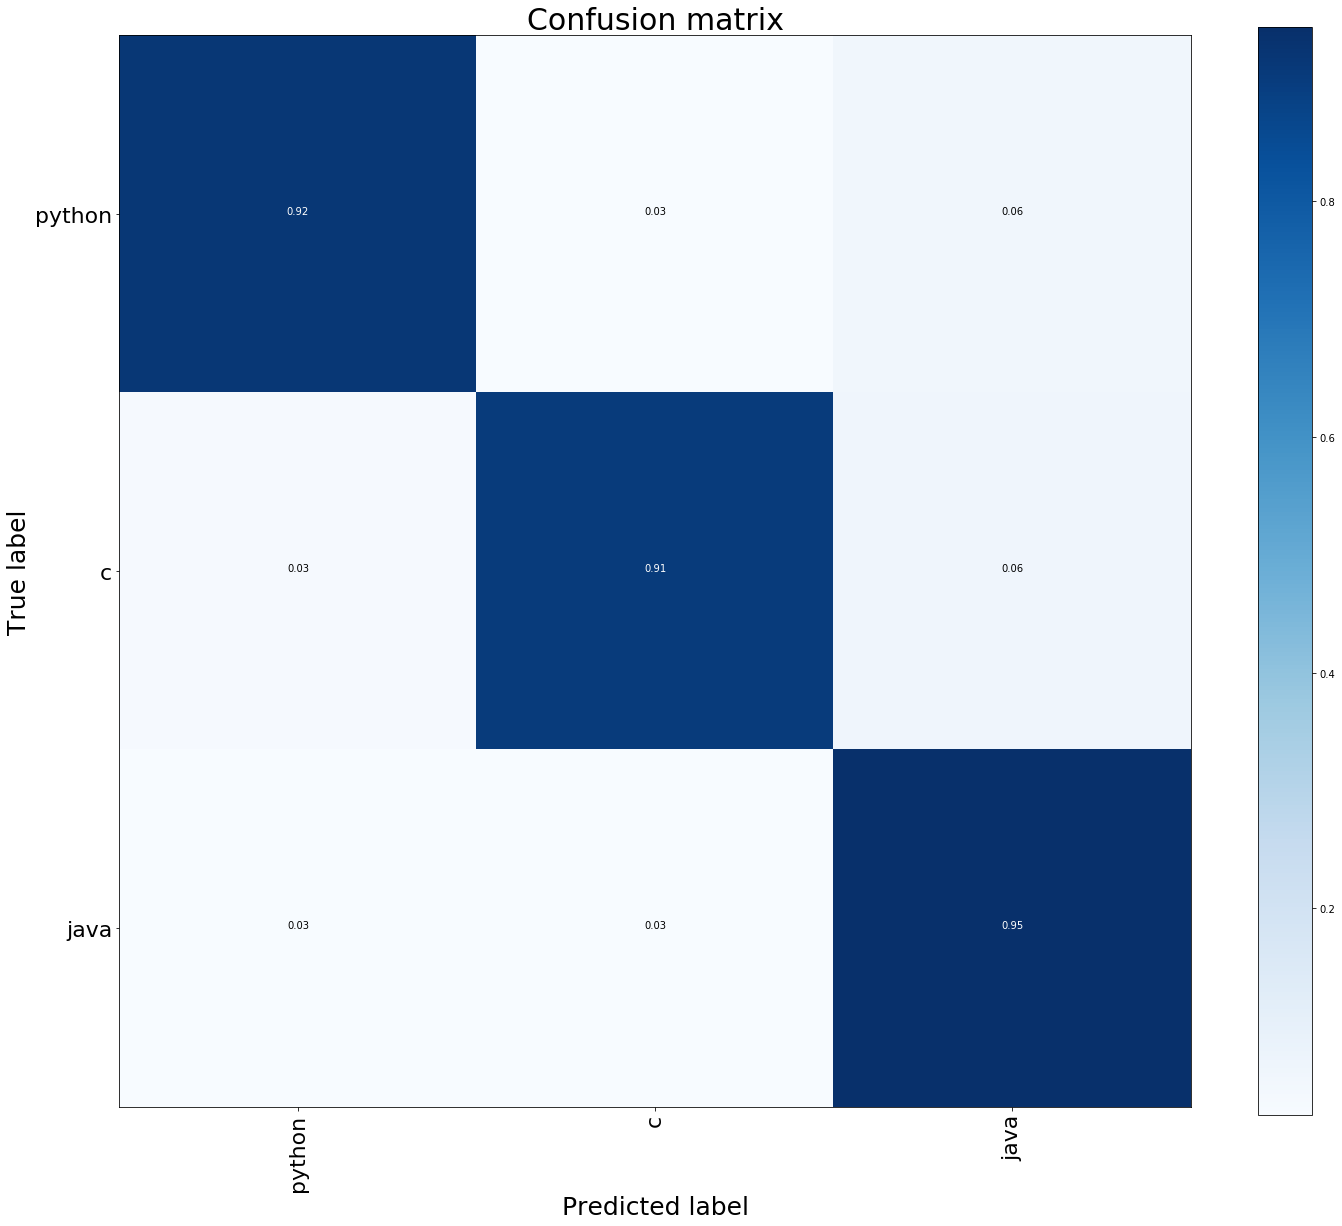

In [23]:
import numpy as np
from app.visualization import (plot_prediction_metrics,
                               create_clf_report,
                               plot_roc_curve,
                               plot_precision_recall_curve,
                               plot_confusion_matrix)
import matplotlib.pylab as plt

prediction_val = model.predict(model_data['x_test'], batch_size=best_model_params['batch_size'])

# returns each entry result to the classification with the relevant probabilities
y_pred_processed = np.array([np.argmax(val) for val in prediction_val])
y_true_processed = np.array([np.argmax(val) for val in model_data['y_test']])

# If you want to see the OneVSAll ROC Curves of each class uncomment the below line
# plot_roc_curve(model_data['y_test'], prediction_val, Classes, 1)

# If you want to see the OneVSAll Precission Recall Curves of each class, comment out the below line
# plot_precision_recall_curve(model_data['y_test'], prediction_val, Classes , 1)

# If you want to get the Classification Report, comment out the below line
create_clf_report(model_data['y_test'], (prediction_val > 0.5).astype('int32'),
                  y_true_processed, y_pred_processed)

# If you want to get the confusion matrix,comment out the below line
plot_confusion_matrix(y_true_processed, y_pred_processed, Classes)